In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

## Read data

In [3]:
import os
SEQ_LEN = 64
IM_SIZE = 28

In [72]:
def read_img_sequences(path_to_folder, size=500):
    curr_size = 0
    data = []
    labels = []
    
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * SEQ_LEN
        sequence_labels = [None] * SEQ_LEN
        
        for img_path in os.listdir(full_sequence_folder):
            # -3: drop .pt
            im_index, label = img_path[:-3].split('_')
            im_index = int(im_index)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            # load image and reshape to vector
            img = torch.load(full_path_to_img).view(IM_SIZE * IM_SIZE).detach().cpu().numpy()
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [73]:
anomaly_data, anomaly_labels = read_img_sequences('data_4_in_7/img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('data_4_in_7/img_ts_normal/')

In [74]:
len(anomaly_data)

500

In [6]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == 7).astype(int)

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

## Loss function

In [8]:
device = torch.device('cuda')

In [9]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [10]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:0')

In [11]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [12]:
# input data parameters
input_size = IM_SIZE * IM_SIZE
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [13]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [14]:
device = torch.device("cuda:1")

In [15]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [16]:
def train_model(model, loss_function, epochs=100, print_every=5, LSTM_flag = True):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

## LSTM Model

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        #hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        
        return hidden

In [18]:
model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_LSTM_custom.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [19]:
model_LSTM_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 5, LSTM_flag=True)

Epoch: 2/60... Step: 5... Loss: -2.681755... Val Loss: -2.321216
Epoch: 4/60... Step: 10... Loss: -2.651834... Val Loss: -2.573875
Epoch: 5/60... Step: 15... Loss: -2.753232... Val Loss: -3.478682
Epoch: 7/60... Step: 20... Loss: -5.218072... Val Loss: -4.743764
Epoch: 9/60... Step: 25... Loss: -5.620369... Val Loss: -7.879506
Epoch: 10/60... Step: 30... Loss: -7.806432... Val Loss: -6.987410
Epoch: 12/60... Step: 35... Loss: -8.887592... Val Loss: -9.107732
Epoch: 14/60... Step: 40... Loss: -10.282975... Val Loss: -11.211679
Epoch: 15/60... Step: 45... Loss: -11.053198... Val Loss: -11.216989
Epoch: 17/60... Step: 50... Loss: -9.660485... Val Loss: -11.390139
Epoch: 19/60... Step: 55... Loss: -12.885737... Val Loss: -12.442661
Epoch: 20/60... Step: 60... Loss: -13.301723... Val Loss: -13.476248
Epoch: 22/60... Step: 65... Loss: -13.070298... Val Loss: -14.102626
Epoch: 24/60... Step: 70... Loss: -13.484932... Val Loss: -12.865000
Epoch: 25/60... Step: 75... Loss: -12.493529... Val Los

In [20]:
model_LSTM_bce = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_LSTM_bce.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [21]:
model_LSTM_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_LSTM_bce, bce_loss_function, 
                                                                                       60, 5, LSTM_flag=True)

Epoch: 2/60... Step: 5... Loss: 0.640624... Val Loss: 0.598252
Epoch: 4/60... Step: 10... Loss: 0.473078... Val Loss: 0.426478
Epoch: 5/60... Step: 15... Loss: 0.337548... Val Loss: 0.248522
Epoch: 7/60... Step: 20... Loss: 0.196643... Val Loss: 0.151499
Epoch: 9/60... Step: 25... Loss: 0.150982... Val Loss: 0.091316
Epoch: 10/60... Step: 30... Loss: 0.087787... Val Loss: 0.056972
Epoch: 12/60... Step: 35... Loss: 0.060370... Val Loss: 0.039107
Epoch: 14/60... Step: 40... Loss: 0.038836... Val Loss: 0.033888
Epoch: 15/60... Step: 45... Loss: 0.036520... Val Loss: 0.034860
Epoch: 17/60... Step: 50... Loss: 0.033002... Val Loss: 0.026953
Epoch: 19/60... Step: 55... Loss: 0.027592... Val Loss: 0.031628
Epoch: 20/60... Step: 60... Loss: 0.026664... Val Loss: 0.028764
Epoch: 22/60... Step: 65... Loss: 0.044958... Val Loss: 0.040105
Epoch: 24/60... Step: 70... Loss: 0.026872... Val Loss: 0.038525
Epoch: 25/60... Step: 75... Loss: 0.025949... Val Loss: 0.030778
Epoch: 27/60... Step: 80... Los

In [22]:
model_LSTM_combined = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_LSTM_combined.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [23]:
model_LSTM_combined, _ = train_model(model_LSTM_combined, second_custom_loss_function, 30, 5, 
                                    LSTM_flag=True)

Epoch: 2/30... Step: 5... Loss: -2.232289... Val Loss: -2.338677
Epoch: 4/30... Step: 10... Loss: -1.981157... Val Loss: -3.092810
Epoch: 5/30... Step: 15... Loss: -3.059372... Val Loss: -3.266315
Epoch: 7/30... Step: 20... Loss: -4.095883... Val Loss: -4.764972
Epoch: 9/30... Step: 25... Loss: -4.587253... Val Loss: -5.898686
Epoch: 10/30... Step: 30... Loss: -8.145972... Val Loss: -7.602304
Epoch: 12/30... Step: 35... Loss: -9.029346... Val Loss: -7.900010
Epoch: 14/30... Step: 40... Loss: -10.640846... Val Loss: -11.117276
Epoch: 15/30... Step: 45... Loss: -9.687943... Val Loss: -10.755190
Epoch: 17/30... Step: 50... Loss: -12.954045... Val Loss: -12.689969
Epoch: 19/30... Step: 55... Loss: -12.355498... Val Loss: -12.430106
Epoch: 20/30... Step: 60... Loss: -11.901297... Val Loss: -13.410977
Epoch: 22/30... Step: 65... Loss: -13.504298... Val Loss: -12.515906
Epoch: 24/30... Step: 70... Loss: -14.516963... Val Loss: -15.293420
Epoch: 25/30... Step: 75... Loss: -11.735942... Val Los

In [24]:
model_LSTM_combined, __ = train_model(model_LSTM_combined, first_bce_loss_function, 30, 5, 
                                      LSTM_flag=True)

Epoch: 2/30... Step: 5... Loss: 0.101673... Val Loss: 0.060268
Epoch: 4/30... Step: 10... Loss: 0.063486... Val Loss: 0.041647
Epoch: 5/30... Step: 15... Loss: 0.058853... Val Loss: 0.032037
Epoch: 7/30... Step: 20... Loss: 0.039680... Val Loss: 0.026480
Epoch: 9/30... Step: 25... Loss: 0.031794... Val Loss: 0.031841
Epoch: 10/30... Step: 30... Loss: 0.035171... Val Loss: 0.024613
Epoch: 12/30... Step: 35... Loss: 0.025506... Val Loss: 0.029228
Epoch: 14/30... Step: 40... Loss: 0.026365... Val Loss: 0.027593
Epoch: 15/30... Step: 45... Loss: 0.031297... Val Loss: 0.026880
Epoch: 17/30... Step: 50... Loss: 0.022525... Val Loss: 0.022930
Epoch: 19/30... Step: 55... Loss: 0.023792... Val Loss: 0.025874
Epoch: 20/30... Step: 60... Loss: 0.017815... Val Loss: 0.022223
Epoch: 22/30... Step: 65... Loss: 0.018194... Val Loss: 0.022919
Epoch: 24/30... Step: 70... Loss: 0.024193... Val Loss: 0.021663
Epoch: 25/30... Step: 75... Loss: 0.016279... Val Loss: 0.023061
Epoch: 27/30... Step: 80... Los

## FNN Models

In [25]:
class FNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, drop_prob=0.5):
        super(FNN, self).__init__()
        # Linear function as in LSTM model

        self.linear_1 = nn.Linear(input_size, hidden_dim) 
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim//2) 
        self.linear_3 = nn.Linear(hidden_dim//2, 1)  
        self.dropout = nn.Dropout(drop_prob)
        self.relu = nn.ReLU()
        self.activation = nn.Sigmoid()


    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        out = self.linear_1(input_seq)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_3(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)
        return out

In [26]:
model_FNN_custom = FNN(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size)
loss_function = CustomLoss()
model_FNN_custom.to(device)

FNN(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (activation): Sigmoid()
)

In [27]:
model_FNN_custom, (loss_list, acc_list, overall_val_loss_list) = train_model(model_FNN_custom, loss_function, 
                                                                             20, 5, LSTM_flag=False)

Epoch: 2/20... Step: 5... Loss: -2.184840... Val Loss: -2.720031
Epoch: 4/20... Step: 10... Loss: -3.868064... Val Loss: -4.353974
Epoch: 5/20... Step: 15... Loss: -4.366529... Val Loss: -5.263832
Epoch: 7/20... Step: 20... Loss: -6.058733... Val Loss: -7.322254
Epoch: 9/20... Step: 25... Loss: -6.339879... Val Loss: -7.608167
Epoch: 10/20... Step: 30... Loss: -6.241182... Val Loss: -7.265013
Epoch: 12/20... Step: 35... Loss: -6.581733... Val Loss: -7.644633
Epoch: 14/20... Step: 40... Loss: -7.507641... Val Loss: -6.916762
Epoch: 15/20... Step: 45... Loss: -7.017776... Val Loss: -6.178002
Epoch: 17/20... Step: 50... Loss: -8.198262... Val Loss: -6.559602
Epoch: 19/20... Step: 55... Loss: -7.983094... Val Loss: -6.247005
Epoch: 20/20... Step: 60... Loss: -8.635077... Val Loss: -7.816842


In [28]:
model_FNN_bce = FNN(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size)
bce_loss_function = torch.nn.BCELoss()
model_FNN_bce.to(device)

FNN(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (activation): Sigmoid()
)

In [29]:
model_FNN_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_FNN_bce, bce_loss_function, 20, 5, LSTM_flag=False)

Epoch: 2/20... Step: 5... Loss: 0.614158... Val Loss: 0.571019
Epoch: 4/20... Step: 10... Loss: 0.494157... Val Loss: 0.412786
Epoch: 5/20... Step: 15... Loss: 0.355303... Val Loss: 0.267481
Epoch: 7/20... Step: 20... Loss: 0.210792... Val Loss: 0.167129
Epoch: 9/20... Step: 25... Loss: 0.166365... Val Loss: 0.096702
Epoch: 10/20... Step: 30... Loss: 0.102386... Val Loss: 0.065115
Epoch: 12/20... Step: 35... Loss: 0.066434... Val Loss: 0.044108
Epoch: 14/20... Step: 40... Loss: 0.076177... Val Loss: 0.037484
Epoch: 15/20... Step: 45... Loss: 0.078193... Val Loss: 0.035654
Epoch: 17/20... Step: 50... Loss: 0.066004... Val Loss: 0.030027
Epoch: 19/20... Step: 55... Loss: 0.067359... Val Loss: 0.027867
Epoch: 20/20... Step: 60... Loss: 0.064049... Val Loss: 0.032535


In [30]:
model_FNN_combined = FNN(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_FNN_combined.to(device)

FNN(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (activation): Sigmoid()
)

In [31]:
model_FNN_combined, _ = train_model(model_FNN_combined, first_bce_loss_function, 5, 5, LSTM_flag=False)

Epoch: 2/5... Step: 5... Loss: 0.587205... Val Loss: 0.549638
Epoch: 4/5... Step: 10... Loss: 0.476911... Val Loss: 0.383496
Epoch: 5/5... Step: 15... Loss: 0.316435... Val Loss: 0.267991


In [32]:
model_FNN_combined, __ = train_model(model_FNN_combined, second_custom_loss_function, 5, 5, LSTM_flag=False)

Epoch: 2/5... Step: 5... Loss: -6.897084... Val Loss: -7.449935
Epoch: 4/5... Step: 10... Loss: -7.140560... Val Loss: -7.774478
Epoch: 5/5... Step: 15... Loss: -6.876730... Val Loss: -8.049295


## Calculate metrics for different models

In [33]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [34]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=True):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:

        if test_inputs.shape[0] < test_batch_size:
            break
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)

        if LSTM_flag:
            test_hidden = model.init_hidden(batch_size)
            #test_hidden = tuple([each.data for each in test_hidden])
            test_predictions, test_hidden = model(test_inputs, test_hidden)
        else:
            test_predictions = model(test_inputs)
            
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [35]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list, LSTM_flag=True):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold, LSTM_flag)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        #print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

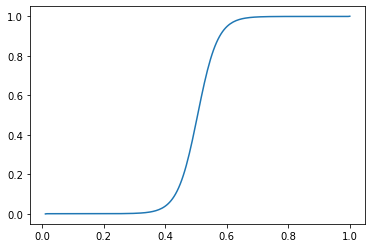

In [36]:
threshold_number = 200
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]
plt.plot(np.linspace(0.01, 1, threshold_number + 2), threshold_list)

In [37]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_bce, fn_number_list_LSTM_bce, 
 delay_list_LSTM_bce, fp_delay_list_LSTM_bce) = get_pareto_metrics_for_threshold(model_LSTM_bce, final_test_loader, 
                                                                                 threshold_list, LSTM_flag=True)

In [38]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
 delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                       threshold_list, LSTM_flag=True)

In [39]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_combined, fn_number_list_LSTM_combined, delay_list_LSTM_combined, fp_delay_list_LSTM_combined) = get_pareto_metrics_for_threshold(model_LSTM_combined, final_test_loader, threshold_list, LSTM_flag=True)

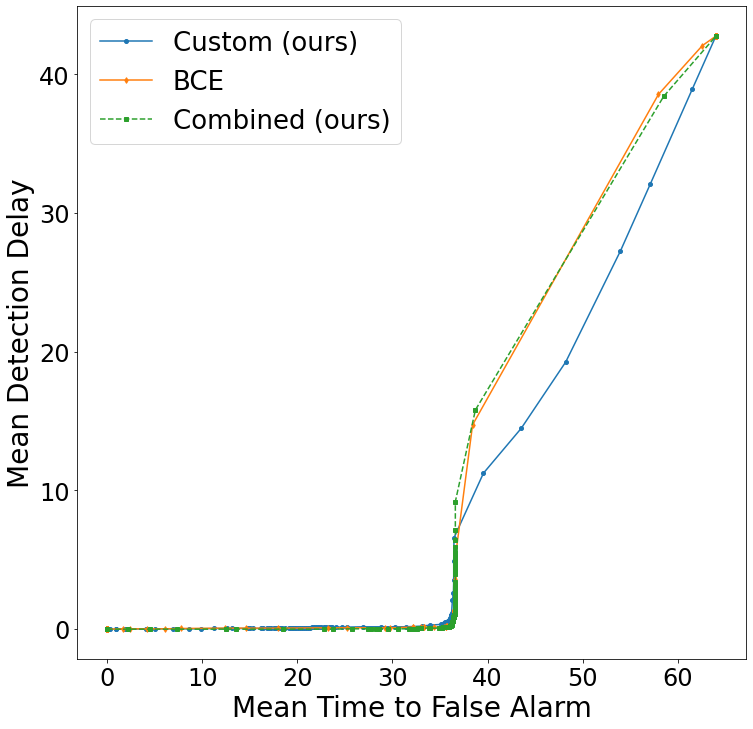

In [42]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('mnist_4_in_7_curve.pdf', bbox_inches='tight')


#plt.figure(figsize=(12, 12))
#plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', label='LSTM. CustomLoss model')
#plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', label='LSTM.BCELoss model')
#plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '-s', label='LSTM. Combined model')
#plt.plot(fp_delay_list_FNN_custom, delay_list_FNN_custom, '-o', label='FNN. CustomLoss model')
#plt.plot(fp_delay_list_FNN_bce, delay_list_FNN_bce, '-d', label='LSTM.BCELoss model')
#plt.plot(fp_delay_list_FNN_combined, delay_list_FNN_combined, '-s', label='FNN. Combined model')



#plt.xlabel('Mean FP delay')
#plt.ylabel('Mean delay')
#plt.yscale('log')
#plt.legend(loc='upper left', fontsize=14);

In [ ]:
def save_metrics_to_file_new_version(model_name, model, test_loader, batch_size,
                                     seq_len, fp_delay, threshold_list, x_coord_arr, path_to_save = ""):
  columns_list = ["Model name", "Mean FP delay", "Mean delay", "Threshold", "TP", "TN", "FP", "FN", "Acc",
                "Precision", "Recall", "F1-score", "G-mean"]
  data_model_results = metrics_by_fp_delay_x_coord(model_name, model, test_loader, batch_size, seq_len,
                                                   fp_delay, threshold_list, x_coord_arr)
  df_main = pd.DataFrame(data_model_results, columns = columns_list)
  df_main.to_excel(os.path.join(path_to_save, model_name + ".xlsx" ), index = False)

In [48]:
%load_ext autoreload
%autoreload 1
%aimport metrics


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
model_LSTM_custom.to('cuda:0')

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [54]:
metrics.save_metrics_to_file_new_version('Custom', model_LSTM_custom, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_custom, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 39.99, 45, 50], path_to_save = "")

33.984375 0.33662029495232143 35.078125 0.3710679107501842 35
TP: 12 TN: 29 FP: 23 FN: 0 DELAY: 0.125 FP_DELAY 43.671875
39.5625 0.9564971876670771 43.546875 0.9623558248267451 39.99
TP: 14 TN: 38 FP: 6 FN: 6 DELAY: 5.21875 FP_DELAY 50.515625
43.546875 0.9623558248267451 48.21875 0.9674523120684658 45
TP: 7 TN: 36 FP: 2 FN: 19 DELAY: 10.328125 FP_DELAY 57.28125
48.21875 0.9674523120684658 53.96875 0.9718789695244026 50
TP: 6 TN: 38 FP: 1 FN: 19 DELAY: 10.0625 FP_DELAY 58.578125


In [63]:
metrics.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom)

647.280487804878

In [64]:
model_LSTM_bce.to('cuda:0')

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [65]:
metrics.save_metrics_to_file_new_version('BCE', model_LSTM_bce, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_bce, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 39.9, 45, 50], path_to_save = "")

34.328125 0.02812103047559733 35.375 0.03254768793153412 35
TP: 12 TN: 35 FP: 17 FN: 0 DELAY: 0.265625 FP_DELAY 43.5
38.421875 0.9999401505276208 57.96875 0.9999485254648226 39.9
TP: 27 TN: 35 FP: 1 FN: 1 DELAY: 5.890625 FP_DELAY 47.953125
38.421875 0.9999401505276208 57.96875 0.9999485254648226 45
TP: 22 TN: 34 FP: 1 FN: 7 DELAY: 9.84375 FP_DELAY 50.796875
38.421875 0.9999401505276208 57.96875 0.9999485254648226 50
TP: 16 TN: 33 FP: 1 FN: 14 DELAY: 13.75 FP_DELAY 55.203125


In [66]:
metrics.area_under_graph(delay_list_LSTM_bce, fp_delay_list_LSTM_bce)

788.3809070121953

In [68]:
metrics.save_metrics_to_file_new_version('Cobined', model_LSTM_combined, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_combined, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 40, 45, 50], path_to_save = "")

34.984375 0.01807518260025041 35.125 0.020954573680812282 35
TP: 8 TN: 35 FP: 21 FN: 0 DELAY: 0.03125 FP_DELAY 46.4375
38.71875 0.9998521398034467 58.515625 0.9998728288098837 40
TP: 26 TN: 37 FP: 0 FN: 1 DELAY: 6.375 FP_DELAY 47.84375
38.71875 0.9998521398034467 58.515625 0.9998728288098837 45
TP: 19 TN: 34 FP: 0 FN: 11 DELAY: 11.359375 FP_DELAY 52.953125
38.71875 0.9998521398034467 58.515625 0.9998728288098837 50
TP: 9 TN: 40 FP: 0 FN: 15 DELAY: 12.015625 FP_DELAY 58.875


In [69]:
metrics.area_under_graph(delay_list_LSTM_combined, fp_delay_list_LSTM_combined)

786.539824695122

In [60]:
model_LSTM_combined.to('cuda:0')

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [62]:
metrics.save_metrics_to_file_new_version('Combined', model_LSTM_bce, val_loader, batch_size=64,
                                         seq_len=64, fp_delay=fp_delay_list_LSTM_custom, 
                                         threshold_list=threshold_list, 
                                         x_coord_arr=[35, 39.99, 45, 50], path_to_save = "")

33.984375 0.33662029495232143 35.078125 0.3710679107501842 35
TP: 18 TN: 36 FP: 10 FN: 0 DELAY: 0.4375 FP_DELAY 46.375
39.5625 0.9564971876670771 43.546875 0.9623558248267451 39.99
TP: 22 TN: 33 FP: 9 FN: 0 DELAY: 0.609375 FP_DELAY 44.703125
43.546875 0.9623558248267451 48.21875 0.9674523120684658 45
TP: 20 TN: 36 FP: 8 FN: 0 DELAY: 0.59375 FP_DELAY 47.453125
48.21875 0.9674523120684658 53.96875 0.9718789695244026 50
TP: 17 TN: 39 FP: 8 FN: 0 DELAY: 0.28125 FP_DELAY 48.609375
